In [1]:
# Chargement des packages nécessaires
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df_merged = pd.read_csv('../data/data 2020-2022.csv', low_memory = False)
df_merged.head()

,Num_Acc,place,catu,grav,sexe,trajet,secu,locp,actp,etatp,...,agg,int,atm,col,com,adr,gps,lat,long,dep
0,202000000001,1.0,1,1,1,5.0,NaN,-1.0,-1,-1.0,...,2,3,1.0,3.0,91657,HENRI BARBUSSE (AVENUE),NaN,"48,7053500","2,4384100",91
1,202000000001,1.0,1,3,1,5.0,NaN,-1.0,-1,-1.0,...,2,3,1.0,3.0,91657,HENRI BARBUSSE (AVENUE),NaN,"48,7053500","2,4384100",91
2,202000000002,1.0,1,1,1,1.0,NaN,-1.0,-1,-1.0,...,2,9,7.0,6.0,91657,MOUSSEAUX(CHEMIN),NaN,"48,6900000","2,4100000",91
3,202000000002,10.0,3,4,1,5.0,NaN,3.0,3,1.0,...,2,9,7.0,6.0,91657,MOUSSEAUX(CHEMIN),NaN,"48,6900000","2,4100000",91
4,202000000003,1.0,1,1,1,0.0,NaN,-1.0,-1,-1.0,...,2,2,1.0,3.0,91174,CARNOT(AVENUE),NaN,"48,6106700","2,4758200",91


## Pré-traitement

Observations dupliquées ?

In [7]:
print('Nombre de lignes dupliquées :', df_merged.duplicated().sum())

Nombre de lignes dupliquées : 63


In [9]:
# On supprime les lignes dupliquées

df_merged = df_merged.drop_duplicates(keep = 'first')

In [11]:
print('Nombre de lignes dupliquées :', df_merged.duplicated().sum())

Nombre de lignes dupliquées : 0


Les variables peuvent prendre la valeur de '-1' qui signifie 'Non renseigné'. Pour mieux gérer le nettoyage du df, on remplace cette valeur par un NaN.


In [14]:
df_merged = df_merged.replace(-1, np.nan)
df_merged = df_merged.replace('-1', np.nan)  # Si format txt
df_merged = df_merged.replace(' -1', np.nan)  # Si format txt

Visualisation des taux de NaN par variable

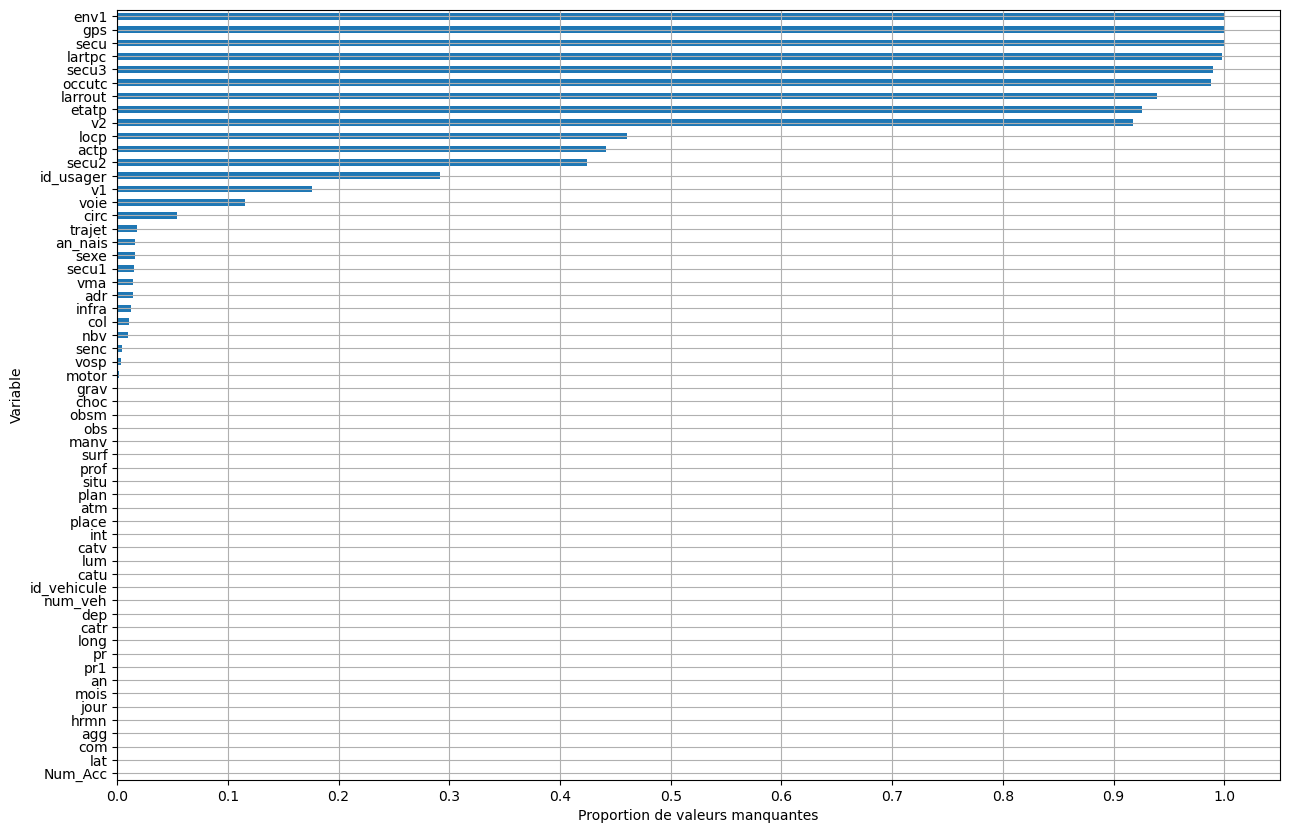

In [17]:
nan_col = df_merged.isna().sum().sort_values(ascending=True)/df_merged.shape[0]
nan_col.plot.barh(figsize=(15,10))  # On trace via pandas
plt.xticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.grid(True)
plt.xlabel('Proportion de valeurs manquantes')
plt.ylabel('Variable')
plt.show();

Les variables suivantes ont des taux de NaN supérieurs à 10% :
- lartpc : largeur du TPC si existe
- secu3 : Présence et utilisation d'un équipeemnt de sécurité (3eme renseignement possible)
- occutc : Nb d'occupants dans le transport en commun
- larrout : Largeur de la chaussée
- etatp : Si piéton accidenté accompagné ou non
- v2 : Lettre indice alphanum de la route
- locp : Localisation du piéton
- actp : Action du piéton
- secu2 : Présence et utilisation d'un équipeemnt de sécurité (2eme renseignement possible)
- id_usager : Identifiant unique de l'usager (que depuis 2021)
- v1 : Indice num du numéro de route
- voie : Numéro de la route

Au vu du nombre important de NaN, ces variables ne seront pas analysées (gestion des NaN peu envisageable). Nous faisons cependant l'exception pour les équipements de sécurité. Ils seront regroupés dans des variables pour chaque élément.

3 variables concernant les piétons sont également non utilisables. Pour la suite, on retirera également les autres variables en lien avec des piétons (catu = 3 (Piéton))

Pour la localisation des accidents, du fait d'avoir les latitudes et longitudes, nous pouvons supprimer les autres variables. Nous gardons tout de même la variable dep (département) et com (commune).

In [21]:
df_merged = df_merged.drop(['lartpc', 'occutc', 'larrout', 'etatp', 'locp', 'actp', 'id_usager',
                            'voie', 'v1', 'v2', 'adr', 'pr', 'pr1'], axis=1)

df_merged = df_merged[df_merged["catu"] != 3]

On trie les variables 'secu', 'secu2' et 'secu3'

In [24]:
df_merged['Ceinture'] = df_merged[['secu1', 'secu2', 'secu3']].isin([1]).any(axis=1)
df_merged['Casque'] = df_merged[['secu1', 'secu2', 'secu3']].isin([2]).any(axis=1)
df_merged['Dispositif enfants'] = df_merged[['secu1', 'secu2', 'secu3']].isin([3]).any(axis=1)
df_merged['Gilet réfléchissant'] = df_merged[['secu1', 'secu2', 'secu3']].isin([4]).any(axis=1)
df_merged['Airbag'] = df_merged[['secu1', 'secu2', 'secu3']].isin([5, 7]).any(axis=1)
df_merged['Gants'] = df_merged[['secu1', 'secu2', 'secu3']].isin([6, 7]).any(axis=1)
df_merged['Autre equipement'] = df_merged[['secu1', 'secu2', 'secu3']].isin([9]).any(axis=1)

df_merged = df_merged.drop(['secu1', 'secu2', 'secu3'], axis=1)

On enlève les limitations de vitesse > à 130 km/h

In [27]:
df_merged.loc[df_merged['vma'] > 130, 'vma'] = np.nan

On convertit dans le bon format les latitudes et longitudes

In [30]:
df_merged['lat'] = df_merged['lat'].str.replace(',', '.').astype(float)
df_merged['long'] = df_merged['long'].str.replace(',', '.').astype(float)

On ne garde pas les victimes trop vieilles

In [33]:
df_merged = df_merged[df_merged["an_nais"] >= 1920]

In [35]:
# On convertit le df pour avoir des dates exploitables

df_merged['date'] = df_merged['jour'].astype(str) + '-' + df_merged['mois'].astype(str) + '-' + df_merged['an'].astype(str) + '-' 
df_merged['date'] = pd.to_datetime(df_merged['date'], dayfirst=True)


In [36]:
# On crée une variable région

region = pd.read_csv("../data/departements-region.csv")
region = region.rename(columns={'num_dep': 'dep'})

df_merged = df_merged.merge(region, how='left', on='dep')

### Traitement de la donnée en vue de la modélisation
Ce regroupement se base sur les observations faites lors de la data visualisation

In [40]:
# On crée une variable heure

df_merged['hrmn'] = df_merged['hrmn'].str.replace(':', '')
df_merged['heure'] = df_merged['hrmn'].astype(int)//100

# On supprime la variable initiale
df_merged = df_merged.drop(['hrmn'], axis=1)


In [42]:
# Variable place : place dans le véhicule

# Modalité : 1 à 9
# On regroupe en 3 catégories : conducteur, passager avant, passager arrière
df_merged['place'] = df_merged['place'].astype(int)

df_merged['conducteur'] = df_merged['place'].apply(lambda x: 1 if x==1 else 0)
df_merged['passager_avant'] = df_merged['place'].apply(lambda x: 1 if x in [2, 6] else 0)
df_merged['passager_arrière'] = df_merged['place'].apply(lambda x: 1 if x not in [1, 2, 6] else 0)

# On supprime la variable initiale
df_merged = df_merged.drop(['place'], axis=1)


In [44]:
# Variable catu : conducteur ou passager

# Modalité 1 (conducteur) ou 2 (passager)
# Le nombre d'occurence entre conducteur ou passager n'est pas cohérent avec celui de la variable place
# (263561 conducteurs contre 263915 pour variable catu)
# On garde la variable place car plus précise

df_merged = df_merged.drop(['catu'], axis=1)


In [46]:
# Variable grav : gravité de l'accident

# Modalité : 'Indemne' (1), 'Tué' (2), 'Blessé hospitalisé' (3), 'Blessé léger' (4)
# Variable cible
# On supprime le seul NaN présent

df_merged = df_merged.dropna(subset=['grav'])
df_merged['grav'] = df_merged['grav'].astype(int)


In [48]:
# Variable sexe : sexe de l'usager

# Modalité : Masculin' (1), 'Féminin' (2)
# Nb NaN : 4, on remplace par le mode

df_merged['sexe'] = df_merged['sexe'].fillna(df_merged['sexe'].mode()[0])
df_merged['sexe'] = df_merged['sexe'].astype(int)


In [50]:
# Variable an_nais : année de naissance de l'usager

# On tranforme cette variable pour connaître l'âge de l'usager
df_merged['an_nais'] = df_merged['an_nais'].astype(int)

df_merged['age'] = df_merged['an'] - df_merged['an_nais']


In [52]:
# Variable trajet : motif du trajet

# Modalité : 5.  9.  4.  0. nan  2.  3.  1.
# Nb NaN : 503, on remplace par le mode

df_merged['trajet'] = df_merged['trajet'].replace(0, np.nan)
df_merged['trajet'] = df_merged['trajet'].fillna(df_merged['trajet'].mode()[0])
df_merged['trajet'] = df_merged['trajet'].astype(int)

# On regroupe en 3 catégorie : autre, pro ou perso
df_merged['trajet_pro'] = df_merged['trajet'].apply(lambda x: 1 if x in [1, 4] else 0)
df_merged['trajet_perso'] = df_merged['trajet'].apply(lambda x: 1 if x in [2, 3, 5] else 0)
df_merged['trajet_autre'] = df_merged['trajet'].apply(lambda x: 1 if x==9 else 0)

df_merged = df_merged.drop(['trajet'], axis=1)


In [54]:
# Variable senc : sens de circulation

# Modalité : 0 1 2 3
# Nb NaN : 1376, on les place dans la catégorie inconnu

df_merged['senc'] = df_merged['senc'].fillna(0)
df_merged['senc'] = df_merged['senc'].astype(int)


In [56]:
# Variable catv : categorie du vehicule

# Modalité : nombreuse
# Nb NaN : 3, on les place dans le mode

df_merged['catv'] = df_merged['catv'].fillna(0)
df_merged['catv'] = df_merged['catv'].astype(int)

# On regroupe en sous-catégorie
df_merged['catv_velo'] = df_merged['catv'].apply(lambda x: 1 if x in [1,80] else 0)
df_merged['catv_moto'] = df_merged['catv'].apply(lambda x: 1 if x in [2,4,5,30,31,32,33,34] else 0)
df_merged['catv_voiture'] = df_merged['catv'].apply(lambda x: 1 if x in [7] else 0)
df_merged['catv_utilitaire'] = df_merged['catv'].apply(lambda x: 1 if x in [10] else 0)
df_merged['catv_veh_remorque'] = df_merged['catv'].apply(lambda x: 1 if x in [8,9,11,12] else 0)
df_merged['catv_PL'] = df_merged['catv'].apply(lambda x: 1 if x in [13,14,15] else 0)
df_merged['catv_tracteur'] = df_merged['catv'].apply(lambda x: 1 if x in [16,17,21] else 0)
df_merged['catv_tram_train'] = df_merged['catv'].apply(lambda x: 1 if x in [19,39,40] else 0)
df_merged['catv_quad_3roues'] = df_merged['catv'].apply(lambda x: 1 if x in [135,36,41,42,43] else 0)
df_merged['catv_autre_inconnu'] = df_merged['catv'].apply(lambda x: 1 if x in [0,3,6,18,20,99] else 0)
df_merged['catv_bus_car'] = df_merged['catv'].apply(lambda x: 1 if x in [37,38] else 0)
df_merged['catv_EDP'] = df_merged['catv'].apply(lambda x: 1 if x in [50,60] else 0)

df_merged = df_merged.drop(['catv'], axis=1)


In [57]:
# Variable obs : obstacle heurté

# Modalité : nombreuse
# Nb NaN : 94, on les place dans le mode

df_merged['obs'] = df_merged['obs'].fillna(df_merged['obs'].mode()[0])
df_merged['obs'] = df_merged['obs'].astype(int)


In [60]:
# Variable obsm : obstacle mobile heurté

# Modalité : nombreuse
# Nb NaN : 129, on les place dans le mode

df_merged['obsm'] = df_merged['obsm'].fillna(df_merged['obsm'].mode()[0])
df_merged['obsm'] = df_merged['obsm'].astype(int)


In [62]:
# Variable choc : point de choc

# Modalité : 0 à 9
# Nb NaN : 118, on les place dans le mode

df_merged['choc'] = df_merged['choc'].fillna(df_merged['choc'].mode()[0])
df_merged['choc'] = df_merged['choc'].astype(int)

# On regroupe en sous-catégorie
df_merged['choc_avant'] = df_merged['choc'].apply(lambda x: 1 if x in [1,2,3] else 0)
df_merged['choc_arriere'] = df_merged['choc'].apply(lambda x: 1 if x in [4,5,6] else 0)
df_merged['choc_cote'] = df_merged['choc'].apply(lambda x: 1 if x in [7,8] else 0)
df_merged['choc_tonneaux'] = df_merged['choc'].apply(lambda x: 1 if x in [9] else 0)
df_merged['choc_aucun'] = df_merged['choc'].apply(lambda x: 1 if x in [0] else 0)

df_merged = df_merged.drop(['choc'], axis=1)


In [64]:
# Variable manv : manoeuvre lors de l'accident

# Modalité : nombreuse
# Nb NaN : 79, on les place dans le mode

df_merged['manv'] = df_merged['manv'].fillna(df_merged['manv'].mode()[0])
df_merged['manv'] = df_merged['manv'].astype(int)

# On regroupe en sous-catégorie
df_merged['manv_diverse'] = df_merged['manv'].apply(lambda x: 1 if x in [3,4,5,6,7,8,9,10,19,20,21,22,23,24,25,26] else 0)
df_merged['manv_droite'] = df_merged['manv'].apply(lambda x: 1 if x in [12,14,16,18] else 0)
df_merged['manv_gauche'] = df_merged['manv'].apply(lambda x: 1 if x in [11,13,15,17] else 0)
df_merged['manv_pas_chang_dir'] = df_merged['manv'].apply(lambda x: 1 if x in [1] else 0)
df_merged['manv_meme_sens_file'] = df_merged['manv'].apply(lambda x: 1 if x in [2] else 0)
df_merged['manv_inconnue'] = df_merged['manv'].apply(lambda x: 1 if x in [0] else 0)

df_merged = df_merged.drop(['manv'], axis=1)


In [66]:
# Variable motor : type de moteur

# Modalité : 0 à 6
# Nb NaN : 420

df_merged['motor'] = df_merged['motor'].fillna(0)
df_merged['motor'] = df_merged['motor'].astype(int)


In [68]:
# Variable catr : type de route

# Modalité : 1 à 7, 9
# Nb NaN : 0

df_merged['catr'] = df_merged['catr'].astype(int)


In [70]:

df_merged['circ'] = df_merged['circ'].fillna(0)
df_merged['circ'] = df_merged['circ'].astype(int)

In [72]:
# Variable circ : régime de circulation

# Modalité : 1 à 4
# Nb NaN : 16866 (5% de NaN) -> on essaie de réduire le nb NaN via d'autre variables

# Si voie = autoroute alors nous ne sommes pas en bidirectionnelle (2941 NaN en moins)
df_merged[(df_merged['circ'].isna()) & (df_merged['catr']==1)]['circ'] = 3

# Si nb voie >= 4 alors nous ne sommes pas en bidirectionnelle (2243 NaN en moins)
df_merged[(df_merged['circ'].isna()) & (df_merged['nbv']>=4)]['circ'] = 3

# Si nb voie = 1 alors nous ne sommes pas en bidirectionnelle (2272 NaN en moins)
df_merged[(df_merged['circ'].isna()) & (df_merged['nbv']==1)]['circ'] = 1

# On regroupe en une catégorie : bidirectionnelle ou non

df_merged['circ'] = df_merged['circ'].fillna(df_merged['circ'].mode()[0])
df_merged['chaussee_bidirectionnelle'] = df_merged['circ'].apply(lambda x: 1 if x == 2 else 0)

df_merged['circ'] = df_merged['circ'].astype(int)
df_merged = df_merged.drop(['circ'], axis=1)

TypeError: '>=' not supported between instances of 'str' and 'int'

In [ ]:
# Variable nbv : nombre de voies

# Modalité : 0 à 12
# Nb NaN : 2624

df_merged['nbv'] = df_merged['nbv'].replace('#ERREUR', np.nan)
df_merged['nbv'] = df_merged['nbv'].fillna(df_merged['nbv'].mode()[0])
df_merged['nbv'] = df_merged['nbv'].astype(int)


In [75]:
# Variable vosp : présence d'une voie réservée

# Modalité : 0 à 3
# Nb NaN : 1232

df_merged['vosp'] = df_merged['vosp'].fillna(df_merged['vosp'].mode()[0])
df_merged['voie_reservee'] = df_merged['vosp'].apply(lambda x: 0 if x == 0 else 1)

df_merged = df_merged.drop(['vosp'], axis=1)


In [77]:
# Variable prof : profil en long

# Modalité : 1 à 4
# Nb NaN : 44

df_merged['prof'] = df_merged['prof'].fillna(df_merged['prof'].mode()[0])
df_merged['prof'] = df_merged['prof'].astype(int)


In [79]:
# Variable plan : tracé en plan

# Modalité : 1 à 4
# Nb NaN : 39

df_merged['plan'] = df_merged['plan'].fillna(df_merged['plan'].mode()[0])
df_merged['plan'] = df_merged['plan'].astype(int)


In [81]:
# Variable surf : état de la chaussée

# Modalité : 1 à 9
# Nb NaN : 58

df_merged['surf'] = df_merged['surf'].fillna(df_merged['surf'].mode()[0])
df_merged['surf'] = df_merged['surf'].astype(int)

# On regroupe en une catégorie : chaussée sèche ou non
df_merged['chaussee_seche'] = df_merged['surf'].apply(lambda x: 1 if x == 1 else 0)

df_merged = df_merged.drop(['surf'], axis=1)


In [83]:
# Variable infra : présence d'un aménagement

# Modalité : 0 à 9
# Nb NaN : 3774

df_merged['infra'] = df_merged['infra'].fillna(df_merged['infra'].mode()[0])
df_merged['infra'] = df_merged['infra'].astype(int)


In [85]:
# Variable situ : situation de l'accident

# Modalité : 1 à 8
# Nb NaN : 42

df_merged['situ'] = df_merged['situ'].fillna(df_merged['situ'].mode()[0])
df_merged['situ'] = df_merged['situ'].astype(int)


In [87]:
# Variable vma : vitesse maximale autorisée

# Modalité : nombreuses
# Nb NaN : 4907

df_merged['vma'] = df_merged['vma'].fillna(df_merged['vma'].mode()[0])
df_merged['vma'] = df_merged['vma'].astype(int)

# On regroupe en sous catégorie
df_merged['vma'] = df_merged['vma'].apply(lambda x: 30 if x<=30. else x)


In [89]:
# Variable lum : luminosité

# Modalité : 1 à 5
# Nb NaN : 7

df_merged['lum'] = df_merged['lum'].fillna(df_merged['lum'].mode()[0])
df_merged['lum'] = df_merged['lum'].astype(int)


In [91]:
# Variable agg : si en agglomération

# Modalité : 1, 2
# Nb NaN : 0

df_merged['agg'] = df_merged['agg'].astype(int)


In [93]:
# Variable int : si intersection

# Modalité : 1 à 9
# Nb NaN : 19

df_merged['int'] = df_merged['int'].fillna(df_merged['int'].mode()[0])
df_merged['int'] = df_merged['int'].astype(int)

# On regroupe en sous-catégorie
df_merged['int_aucune'] = df_merged['int'].apply(lambda x: 1 if x in [1] else 0)
df_merged['int_branches'] = df_merged['int'].apply(lambda x: 1 if x in [2,3,4,5] else 0)
df_merged['int_autre'] = df_merged['int'].apply(lambda x: 1 if x in [6,7,8,9] else 0)

df_merged = df_merged.drop(['int'], axis=1)


In [95]:
# Variable atm : condition atmo

# Modalité : 1 à 9
# Nb NaN : 19

df_merged['atm'] = df_merged['atm'].fillna(df_merged['atm'].mode()[0])
df_merged['atm'] = df_merged['atm'].astype(int)

# On regroupe en une catégorie : cbeau temps ou non
df_merged['atm_normal'] = df_merged['atm'].apply(lambda x: 1 if x == 1 else 0)

df_merged = df_merged.drop(['atm'], axis=1)


In [97]:
# Variable col : type de collision

# Modalité : 1 à 7
# Nb NaN : 3646

df_merged['col'] = df_merged['col'].fillna(df_merged['col'].mode()[0])
df_merged['col'] = df_merged['col'].astype(int)


In [99]:
# Variables équipement

for item in ['Ceinture', 'Casque', 'Dispositif enfants', 'Gilet réfléchissant', 'Airbag', 'Gants', 'Autre equipement']:
    df_merged[item] = df_merged[item].apply(lambda x: 1 if x else 0)


In [100]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 327872 entries, 0 to 327872
Data columns (total 78 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   Num_Acc              327872 non-null  int64         
 1   grav                 327872 non-null  int64         
 2   sexe                 327872 non-null  int64         
 3   secu                 0 non-null       float64       
 4   an_nais              327872 non-null  int64         
 5   num_veh              327872 non-null  object        
 6   id_vehicule          327872 non-null  object        
 7   senc                 327872 non-null  int64         
 8   obs                  327872 non-null  int64         
 9   obsm                 327872 non-null  int64         
 10  motor                327872 non-null  int64         
 11  catr                 327872 non-null  int64         
 12  circ                 327872 non-null  int64         
 13  nbv                

In [103]:
df_merged.head()


,Num_Acc,grav,sexe,secu,an_nais,num_veh,id_vehicule,senc,obs,obsm,...,manv_gauche,manv_pas_chang_dir,manv_meme_sens_file,manv_inconnue,voie_reservee,chaussee_seche,int_aucune,int_branches,int_autre,atm_normal
0,202000000001,1,1,NaN,1983,B01,154Â 742Â 274,1,0,2,...,1,0,0,0,0,1,0,1,0,1
1,202000000001,3,1,NaN,1982,A01,154Â 742Â 275,1,0,2,...,0,0,1,0,0,1,0,1,0,1
2,202000000002,1,1,NaN,1997,A01,154Â 742Â 273,3,0,1,...,0,0,0,0,0,1,0,0,1,0
3,202000000003,1,1,NaN,1985,B01,154Â 742Â 271,1,0,2,...,0,1,0,0,0,1,0,1,0,1
4,202000000003,3,1,NaN,2014,B01,154Â 742Â 271,1,0,2,...,0,1,0,0,0,1,0,1,0,1


In [105]:
df_merged.nunique()

Num_Acc           157259
grav                   4
sexe                   2
secu                   0
an_nais              103
                   ...  
chaussee_seche         2
int_aucune             2
int_branches           2
int_autre              2
atm_normal             2
Length: 78, dtype: int64

In [107]:

df_filtre = df_merged.select_dtypes(include=['int', 'float'])



In [109]:
df_filtre = df_filtre.dropna(axis=1, how='all')

In [111]:
df_filtre.info()

<class 'pandas.core.frame.DataFrame'>
Index: 327872 entries, 0 to 327872
Data columns (total 67 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Num_Acc              327872 non-null  int64  
 1   grav                 327872 non-null  int64  
 2   sexe                 327872 non-null  int64  
 3   an_nais              327872 non-null  int64  
 4   senc                 327872 non-null  int64  
 5   obs                  327872 non-null  int64  
 6   obsm                 327872 non-null  int64  
 7   motor                327872 non-null  int64  
 8   catr                 327872 non-null  int64  
 9   circ                 327872 non-null  int64  
 10  prof                 327872 non-null  int64  
 11  plan                 327872 non-null  int64  
 12  infra                327872 non-null  int64  
 13  situ                 327872 non-null  int64  
 14  vma                  327872 non-null  int64  
 15  an                   3

In [113]:
for i in df_filtre:
    print(str(i),':',df_filtre[str(i)].unique())

Num_Acc : [202000000001 202000000002 202000000003 ... 202200055300 202200055301
 202200055302]
grav : [1 3 4 2]
sexe : [1 2]
an_nais : [1983 1982 1997 1985 2014 1963 1991 1987 2001 1972 1989 1966 1962 1980
 1951 1965 1977 1934 2005 1999 1936 1928 1975 1990 1974 1981 1996 1949
 1968 1995 2004 2000 1986 1998 1988 1976 1959 1994 1993 2008 1960 1979
 1971 2010 1992 1953 1947 1942 2002 1973 1961 2018 1978 2016 1950 1940
 1939 1952 1948 1969 1970 1957 1954 2011 2019 1967 1984 1964 2003 1956
 1944 1946 1955 1933 2015 2012 1943 2006 1937 1932 1927 1945 1958 1931
 2020 1941 1926 2009 1938 2017 2013 2007 1935 1929 1930 1925 1921 1923
 1924 1920 2021 1922 2022]
senc : [1 3 2 0]
obs : [ 0 13  9  8  1 17  6 15 12  7  3  2 11 14 16  4 10  5]
obsm : [2 1 0 9 6 4 5]
motor : [1 0 5 3 2 6 4]
catr : [4 3 7 9 1 2 6 5]
circ : [2 0 1 3 4]
prof : [1 2 4 3]
plan : [1 3 2 4]
infra : [0 3 5 2 9 1 6 8 4 7]
situ : [1 8 4 5 3 6 2]
vma : [ 50  30  80 110  70 130  90  40  60  35  55  45 100  65  75]
an : [2020 2021 

In [115]:
from sklearn.tree import DecisionTreeClassifier

In [116]:
feats = df_filtre.drop('grav', axis=1)

target = df_filtre['grav']

In [119]:
from sklearn.model_selection import train_test_split

In [121]:

X_train, X_test, y_train, y_test = train_test_split(feats, target, test_size=0.2, random_state=42)


In [123]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()

In [141]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(max_depth=10, min_samples_split=5)


In [143]:
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, min_samples_split=5)

In [145]:
y_pred = model.predict(X_test)  # Prédictions sur les données de test

In [147]:
print("Score train : ", model.score(X_train, y_train))  # Score d'entraînement
print("Score test : ", model.score(X_test, y_test))  # Score de test

Score train :  0.6566716355886647
Score test :  0.6433549370949295
